In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [18]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))


In [2]:


import cv2
import gtsam
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from scipy.spatial.transform import Rotation as R
import gtsam.utils.plot as gtsam_plot
from warnings import warn
import itertools
import os

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
from IPython.display import display

import rospy
from std_msgs.msg import Header
from geometry_msgs.msg import PoseStamped, Point, Pose, PoseArray
from sensor_msgs.msg import PointCloud2, PointField, Image
from sensor_msgs import point_cloud2 as pc2
import struct
from nav_msgs.msg import Path
from cv_bridge import CvBridge
bridge = CvBridge()



plt.rcParams['figure.figsize'] = [20, 10]


In [4]:
!ls rviz

gentest.rviz


In [8]:

os.system('roscore &')

0

In [11]:
os.system('rosrun rviz rviz -d ./rviz/gentest.rviz &')

0

In [12]:


rospy.init_node('triangulate_test', anonymous=True) 

In [90]:
# class TraceCameras():
#     def __init__(self, topic="debug_poses", frame_id="map"):
#         self.publisher = rospy.Publisher(topic, PoseArray, queue_size=1)
#         self.frame_id = frame_id
        
#     def reset(self):
#         self.poses = []

#     def add_pose(self, R, t):
#         pose = Pose()
#         pose.position.x = t[0]
#         pose.position.y = t[1]
#         pose.position.z = t[2]
#         pose.orientation.x = 0
#         pose.orientation.y = 0
#         pose.orientation.z = .7071
#         pose.orientation.w = .7071
#         poses.append(pose)
    
#     def show_points(self, x,y,z, color):
#         self.reset()
#         for xi, yi, zi in zip(x, y, z):
#             self.add_point([xi, yi, zi], color)
#         self.publish()
        
#     def publish(self):
#         ps = PoseArray()
#         ps.header.frame_id = "/base_link"
#         ps.header.stamp = rospy.Time.now()
#         ps.poses = self.poses
#         self.publisher.publish(ps)

class TracePoints():
    def __init__(self, topic="debug_points", frame_id="map"):
        self.publisher = rospy.Publisher(topic, PointCloud2, queue_size=1)
        self.frame_id = frame_id
        
        self.fields = [PointField('x', 0, PointField.FLOAT32, 1),
          PointField('y', 4, PointField.FLOAT32, 1),
          PointField('z', 8, PointField.FLOAT32, 1),
          # PointField('rgb', 12, PointField.UINT32, 1),
          PointField('rgba', 12, PointField.UINT32, 1),
        ]
        self.reset()

    def reset(self):
        self.points = []

    def add_point(self, point, color):
        x = point[0] / 100.0
        y = point[1] / 100.0
        z = point[2] / 100.0
        r = int(color[0] * 255.0)
        g = int(color[1] * 255.0)
        b = int(color[2] * 255.0)
        a = 255
        rgb = struct.unpack('I', struct.pack('BBBB', b, g, r, a))[0]
        pt = [z,x,y, rgb]
        self.points.append(pt)
    
    def show_points(self, x,y,z, color):
        self.reset()
        for xi, yi, zi in zip(x, y, z):
            self.add_point([xi, yi, zi], color)
        self.publish()
        
    def publish(self):
        header = Header()
        header.frame_id = self.frame_id
        msg = pc2.create_cloud(header, self.fields, self.points)
        self.publisher.publish(msg)

GT = TracePoints("ground_truth")



In [92]:
def sample_spherical(n):

    phi = np.linspace(0, np.pi, n)
    theta = np.linspace(0, 2 * np.pi, n)
    x = np.outer(np.sin(theta), np.cos(phi)).flatten()
    y = np.outer(np.sin(theta), np.sin(phi)).flatten()
    z = np.outer(np.cos(theta), np.ones_like(phi)).flatten()
    points_3d = np.vstack((z,x,y, np.ones(n**2)))
    points_3d *= 30
    return points_3d

points_3d = sample_spherical(15)

def draw_sphere(n=15):
    points_3d = sample_spherical(n)
    GT.show_points(points_3d[0], points_3d[1], points_3d[2], [1,0,0])
#     plt.rcParams['legend.fontsize'] = 10

    # fig = plt.figure(figsize=plt.figaspect(1))
    # ax = fig.gca(projection='3d')

    # ax.scatter(points_3d[2], points_3d[0], points_3d[1], marker='o')
    # ax.legend()

    return plt


    
interact(draw_sphere, n=(0,25,1))

interactive(children=(IntSlider(value=15, description='n', max=25), Output()), _dom_classes=('widget-interact'…

<function __main__.draw_sphere(n=15)>

In [93]:
roll = FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=0.0, description="roll")
pitch = FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=0.0, description="pitch")
yaw = FloatSlider(min=-np.pi, max=np.pi, step=0.1, value=0.0, description="yaw")
rot = widgets.HBox([roll, pitch, yaw])
x = FloatSlider(min=-12, max=12, step=0.2, value=0.0, description="x")
y = FloatSlider(min=-12, max=12, step=0.2, value=0.0, description="y")
z = FloatSlider(min=-12, max=12, step=0.2, value=-3.0, description="z")
noise = FloatSlider(min=0., max=1.2, step=0.02, value=0.0, description="noise")
t = widgets.HBox([x, y, z])
ui = widgets.VBox([rot, t, noise])

norm = np.random.normal

fx, fy = 100.0, 100.0
cx, cy = 200.0, 150.0
s = 0.
width, height = 400, 300

class Camera():
    def __init__(self, rotation, translation):
        self.rotation = rotation
        self.translation = translation
        self.intrinsic = np.array([
            [fx,  s, cx],
            [0., fy, cy],
            [0., 0., 1.]
        ])
        self.pub_image = rospy.Publisher('render', Image, queue_size=1)
        self.pub_camera = rospy.Publisher('camera', PoseStamped, queue_size=1)
    
    def extrinsic(self):
        return np.hstack((self.rotation, self.translation))
    
    def projection(self):
        return  self.intrinsic @ self.extrinsic()

    def project(self, points_3d, noise=0.0):
        assert points_3d.shape[0] == 4
        points_2d = self.projection() @ points_3d
        points_2d = points_2d[:2] / points_2d[2]
        points_2d += np.random.normal(scale=noise, size=points_2d.shape)
        return points_2d
    
    def draw(self, points_2d):
        img = np.ones((height, width,3), np.uint8) * 128
        for x, y in points_2d.T:
            # print("center", center)
            if x >= 0 and y >= 0 and x < width and y < height:
                img = cv2.circle(img, (int(x), int(y)), radius=1, color=(0,255,0), thickness=1)
        self.pub_image.publish(bridge.cv2_to_imgmsg(img, encoding="bgr8"))
        
        pose = PoseStamped()
        pose.header.frame_id = "map"
        pose.pose.position.x = self.translation[2][0]
        pose.pose.position.y = self.translation[0][0]
        pose.pose.position.z = self.translation[1][0]
        quaternion = self.quaternion()
        pose.pose.orientation.x = quaternion[0]
        pose.pose.orientation.y = quaternion[1]
        pose.pose.orientation.z = quaternion[2]
        pose.pose.orientation.w = quaternion[3]
        print(pose)
        self.pub_camera.publish(pose)

    def quaternion(self):
        return R.from_matrix(self.rotation).as_quat()

        
    
    @staticmethod
    def from_rpyxyz(roll=0.,pitch=0.,yaw=0.,x=0.,y=0.,z=-0.):
        rotation = R.from_rotvec((roll, pitch, yaw)).as_matrix()
        translation = np.array([x, y, z])[:, np.newaxis]
        return Camera(rotation, translation)
    
    @staticmethod
    def from_look_at(camera_position, camera_target=np.array([0.,0.,0.])):
        up_vector=np.array([0.,1.,0.])
        vector = camera_position - camera_target
        vector = vector / np.linalg.norm(vector)

        vector2 = np.cross(up_vector, vector)
        vector2 = vector2 / np.linalg.norm(vector2)

        vector3 = np.cross(vector, vector2)
        m = np.array([
            [vector2[0], vector3[0], vector[0], 0.0],
            [vector2[1], vector3[1], vector[1], 0.0],
            [vector2[2], vector3[2], vector[2], 0.0],
            [-np.dot(vector2, camera_position), -np.dot(vector3, camera_position), np.dot(vector, camera_position), 1.0]
        ])
        return Camera(m[:3,:3], camera_position[:,np.newaxis])
        
        


# def perspective_fov(fov, aspect_ratio, near_plane, far_plane):
#     num = 1.0 / np.tan(fov / 2.0)
#     num9 = num / aspect_ratio
#     return np.array([
#         [num9, 0.0, 0.0, 0.0],
#         [0.0, num, 0.0, 0.0],
#         [0.0, 0.0, far_plane / (near_plane - far_plane), -1.0],
#         [0.0, 0.0, (near_plane * far_plane) / (near_plane - far_plane), 0.0]
#     ])

# def look_at(camera_position, camera_target, up_vector):
#     vector = camera_position - camera_target
#     vector = vector / np.linalg.norm(vector)

#     vector2 = np.cross(up_vector, vector)
#     vector2 = vector2 / np.linalg.norm(vector2)

#     vector3 = np.cross(vector, vector2)
#     return np.array([
#         [vector2[0], vector3[0], vector[0], 0.0],
#         [vector2[1], vector3[1], vector[1], 0.0],
#         [vector2[2], vector3[2], vector[2], 0.0],
#         [-np.dot(vector2, camera_position), -np.dot(vector3, camera_position), np.dot(vector, camera_position), 1.0]
#     ])
    
# def project(roll=0.,pitch=0.,yaw=0.,x=0.,y=0.,z=-0.,noise=0.):
#     intrinsic = np.array([
#         [fx,  s, cx],
#         [0., fy, cy],
#         [0., 0., 1.]
#     ])

#     rotation = R.from_rotvec((roll, pitch, yaw)).as_matrix()#
#     translation = np.array([x, y, z])[:, np.newaxis]
#     extrinsic = np.hstack((rotation, translation))
#     projection = intrinsic @ extrinsic

#     points_2d = projection@points_3d
#     points_2d = points_2d[:2] / points_2d[2]
#     points_2d += np.random.normal(scale=noise, size=points_2d.shape)
#     return points_2d, projection

def project_and_plot(roll=0.,pitch=0.,yaw=0.,x=0.,y=0.,z=-0.,noise=0.):
    cam = Camera.from_rpyxyz(roll, pitch, yaw, x, y, z)
#     cam = Camera.from_look_at(np.array([x, y, z]))
#     print((cam.rotation, cam.translation))
    points_2d = cam.project(points_3d, noise)
    cam.draw(points_2d)
    # points_2d, _ = project(roll, pitch, yaw, x, y, z,noise)

    # img = np.ones((width, height), np.uint8) * 255
    # for x, y in points_2d.T:
    #     # print("center", center)
    #     img = cv2.circle(img, (int(x), int(y)), radius=3, color=(0,0,0), thickness=1)

    # plt.figure(figsize=plt.figaspect(height/width))
    # plt.xlim([0,width])
    # plt.ylim([0,height])
    # plt.scatter(points_2d[0], points_2d[1])
    # return print(img.flatten())
    
    
out = widgets.interactive_output(project_and_plot, 
                                 {"roll":roll,"pitch":pitch,"yaw":yaw,"x":x,"y":y,"z":z,"noise":noise})
out.layout.height = '600px'
display(ui, out)

Output(layout=Layout(height='600px'))

In [46]:
look_at(np.array([-1,0,0]), np.array([0,0,-3]),np.array([0,1,0]))

array([[ 0.9486833 ,  0.        , -0.31622777,  0.        ],
       [-0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.31622777,  0.        ,  0.9486833 ,  0.        ],
       [ 0.9486833 , -0.        ,  0.31622777,  1.        ]])

In [36]:
np.eye(4) @ look_at(np.array([-1,1,0]), np.array([0,1,-3]),np.array([0,1,0]))

array([[ 0.9486833 ,  0.        , -0.31622777,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.31622777,  0.        ,  0.9486833 ,  0.        ],
       [ 0.9486833 , -1.        ,  0.31622777,  1.        ]])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

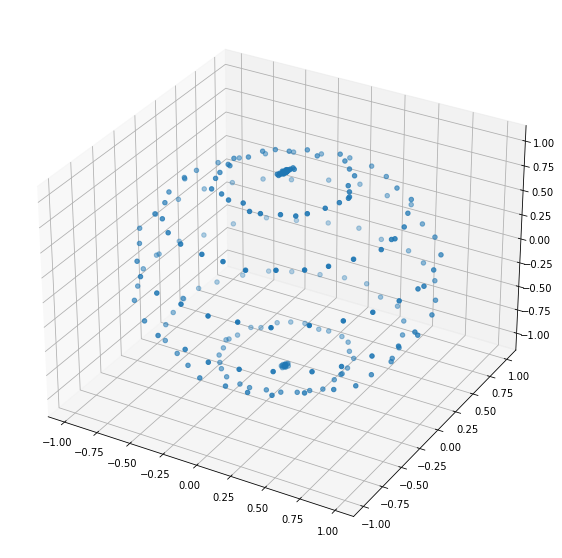

In [13]:
from gtsam.utils import plot

norm = np.random.normal
L = gtsam.symbol_shorthand.L
X = gtsam.symbol_shorthand.X
K = gtsam.Cal3_S2(fx, fy, s, cx, cy)


frames = [(X(i), project(roll=norm(),pitch=norm(),yaw=norm(),x=norm(),y=0.,z=norm(-5), noise=.3)) for i in range(8)]
_, (kps1, proj1) = frames[0]
_, (kps2, proj2) = frames[1]
rp_h = cv2.triangulatePoints(proj1, proj2, kps1, kps2)
rp_3d = rp_h[:3] / rp_h[3]

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.gca(projection='3d')

ax.scatter(rp_3d[2], rp_3d[0], rp_3d[1], marker='o')

plt

In [17]:

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

# Create a factor graph
graph = gtsam.NonlinearFactorGraph()



# Add a prior on pose x1. This indirectly specifies where the origin is.
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))

x0, (_, proj0) = frames[0]
factor = gtsam.PriorFactorPose3(x0, gtsam.Pose3(proj0), pose_noise)
graph.push_back(factor)

for i in range(1, len(frames)):
    

# Add keypoint measurements 
for x_symbol, (kps, proj) in frames:
    graph.add(gtsam.BetweenFactorPose3(i-1, i_ahead, gtsam.Pose3(proj), ODOMETRY_NOISE))

    for j, kp in enumerate(kps.T):
        factor = gtsam.GenericProjectionFactorCal3_S2(
            kp, measurement_noise, x_symbol, L(j), K)
        graph.push_back(factor)
        
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = gtsam.PriorFactorPoint3(L(0), points_3d[:3,0], point_noise)
graph.push_back(factor)
graph.print_('Factor Graph:\n')

initial_estimate = gtsam.Values()
for x_symbol, (kps, proj) in frames:
    transformed_pose = gtsam.Pose3(proj)#.retract(0.1*np.random.randn(6,1))
    initial_estimate.insert(x_symbol, transformed_pose)
for j, point in enumerate(rp_3d.T):
    transformed_point = gtsam.Point3(point)# + 0.1*np.random.randn(3)
    initial_estimate.insert(L(j), transformed_point)
    
def dogleg_optimizer():
    params = gtsam.DoglegParams()
    params.setVerbosity('TERMINATION')
    return gtsam.Cal3_S2(graph, initial_estimate, params)

def gauss_newton_optimizer():
    parameters = gtsam.GaussNewtonParams()
    # Stop iterating once the change in error between steps is less than this value
    parameters.setRelativeErrorTol(1e-5)
    # Do not perform more than N iteration steps
    parameters.setMaxIterations(1000)
    # Create the optimizer ...
    return gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)

def lm_optimizer():
    params = gtsam.LevenbergMarquardtParams()
    params.setVerbosityLM("ERROR")
    return gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)

optimizer = lm_optimizer()
print('Optimizing:')
result = optimizer.optimize()
result.print_('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

marginals = gtsam.Marginals(graph, result)
plot.plot_3d_points(1, result, marginals=marginals)
plot.plot_trajectory(1, result, marginals=marginals, scale=8)
plot.set_axes_equal(1)
plt.show()

Optimizing:
initial error = 1073908422.706425
final error = 1073908422.706425


RuntimeError: 
Indeterminant linear system detected while working near variable
8646911284551352327 (Symbol: x7).

Thrown when a linear system is ill-posed.  The most common cause for this
error is having underconstrained variables.  Mathematically, the system is
underdetermined.  See the GTSAM Doxygen documentation at
http://borg.cc.gatech.edu/ on gtsam::IndeterminantLinearSystemException for
more information.

In [10]:
x, y, z = np.array([result.atPoint3(L(i)) for i in range(points_3d.shape[1])]).T
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.gca(projection='3d')

ax.scatter(x, y, z, marker='o')

plt

NameError: name 'result' is not defined